### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
import time
from collections import deque
import collections
import pickle
import joblib

# for building DQN model
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [((0, 0, 0), (0,1)), ((0, 0, 0), (0,2))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [4]:
States_track = collections.defaultdict(dict)
print(len(States_track))

0


### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        # Initialize the value of the states tracked
        self.states_tracked = []
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.005
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
 
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        input_shape = self.state_size
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]
    
    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save_model_weights(self, name):
        self.model.save_weights(name)

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file, pickle.HIGHEST_PROTOCOL)

In [6]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 2000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

### DQN block

In [7]:
start_time = time.time()
print(time.strftime("Started at GMT: %Y-%m-%d %H:%M:%S", time.gmtime(start_time)))
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in this episode
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipulated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    # agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    # Save model_weights after evrey 100 episodes
    if(episode % 1000 == 0):
        print("Completed {} Episodes".format(episode))
        #agent.save_model_weights(name="model_weights.h5")

elapsed_time = time.time() - start_time
print(elapsed_time)

Started at GMT: 2021-11-21 22:44:38
Completed 0 Episodes
episode 9, reward 262.0, memory_length 1103, epsilon 0.9043820750088043, total_time 729.0
episode 19, reward -24.0, memory_length 2000, epsilon 0.8179069375972307, total_time 722.0
episode 29, reward 415.0, memory_length 2000, epsilon 0.7397003733882802, total_time 722.0
episode 39, reward 531.0, memory_length 2000, epsilon 0.6689717585696803, total_time 724.0
episode 49, reward 486.0, memory_length 2000, epsilon 0.6050060671375365, total_time 722.0
episode 59, reward 576.0, memory_length 2000, epsilon 0.5471566423907612, total_time 722.0
episode 69, reward 1062.0, memory_length 2000, epsilon 0.49483865960020695, total_time 726.0
episode 79, reward 1148.0, memory_length 2000, epsilon 0.44752321376381066, total_time 729.0
episode 89, reward 976.0, memory_length 2000, epsilon 0.4047319726783239, total_time 722.0
episode 99, reward 852.0, memory_length 2000, epsilon 0.36603234127322926, total_time 724.0
episode 109, reward 962.0, me

episode 879, reward 1773.0, memory_length 2000, epsilon 0.004958870278354705, total_time 722.0
episode 889, reward 1827.0, memory_length 2000, epsilon 0.004958870278354705, total_time 727.0
episode 899, reward 1701.0, memory_length 2000, epsilon 0.004958870278354705, total_time 733.0
episode 909, reward 1505.0, memory_length 2000, epsilon 0.004958870278354705, total_time 727.0
episode 919, reward 1528.0, memory_length 2000, epsilon 0.004958870278354705, total_time 724.0
episode 929, reward 2140.0, memory_length 2000, epsilon 0.004958870278354705, total_time 725.0
episode 939, reward 2009.0, memory_length 2000, epsilon 0.004958870278354705, total_time 723.0
episode 949, reward 1951.0, memory_length 2000, epsilon 0.004958870278354705, total_time 724.0
episode 959, reward 1764.0, memory_length 2000, epsilon 0.004958870278354705, total_time 722.0
episode 969, reward 1722.0, memory_length 2000, epsilon 0.004958870278354705, total_time 727.0
episode 979, reward 1583.0, memory_length 2000, ep

episode 1739, reward 2187.0, memory_length 2000, epsilon 0.004958870278354705, total_time 727.0
episode 1749, reward 1681.0, memory_length 2000, epsilon 0.004958870278354705, total_time 721.0
episode 1759, reward 1748.0, memory_length 2000, epsilon 0.004958870278354705, total_time 729.0
episode 1769, reward 1914.0, memory_length 2000, epsilon 0.004958870278354705, total_time 729.0
episode 1779, reward 1760.0, memory_length 2000, epsilon 0.004958870278354705, total_time 723.0
episode 1789, reward 1703.0, memory_length 2000, epsilon 0.004958870278354705, total_time 729.0
episode 1799, reward 1569.0, memory_length 2000, epsilon 0.004958870278354705, total_time 723.0
episode 1809, reward 1904.0, memory_length 2000, epsilon 0.004958870278354705, total_time 729.0
episode 1819, reward 1814.0, memory_length 2000, epsilon 0.004958870278354705, total_time 723.0
episode 1829, reward 2102.0, memory_length 2000, epsilon 0.004958870278354705, total_time 724.0
episode 1839, reward 1663.0, memory_leng

In [8]:
try:
    with open('model_weights.pkl', 'wb') as file:
        pickle.dump(agent, file, pickle.HIGHEST_PROTOCOL)
except: 
    pass

In [9]:
agent.states_tracked

[168.35437,
 288.36362,
 388.94504,
 425.32513,
 407.36353,
 8197.385,
 457.25174,
 405.13034,
 453.83722,
 479.9801,
 453.57828,
 402.1239,
 437.69025,
 444.73734,
 423.80493,
 560.0526,
 395.29956,
 438.71967,
 578.8759,
 554.53516,
 542.80115,
 549.5931,
 513.09503,
 558.4058,
 491.77185,
 591.5337,
 460.6989,
 615.6839,
 564.4029,
 469.07544,
 584.4224,
 611.1889,
 633.16266,
 615.76996,
 573.06006,
 652.4885,
 604.079,
 578.37006,
 546.61316,
 622.67487,
 594.7027,
 590.05774,
 663.76544,
 586.41205,
 652.76807,
 661.22363,
 640.1502,
 641.5847,
 618.62024,
 593.94775,
 611.7278,
 706.49176,
 677.12683,
 647.5027,
 639.2079,
 596.8962,
 670.5769,
 674.2328,
 706.056,
 635.9672,
 623.1688,
 672.191,
 623.9502,
 555.5163,
 621.00104,
 638.8208,
 608.61255,
 632.4842,
 597.80664,
 628.5871,
 571.8111,
 614.25964,
 624.1817,
 633.78674,
 640.09485,
 635.6802,
 623.37885,
 635.96277,
 597.68787,
 619.54065,
 637.43494,
 680.04846,
 605.9494,
 648.7538,
 626.1391,
 632.24786,
 639.3279,

### Tracking Convergence

In [10]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

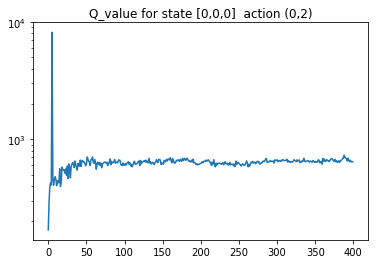

In [11]:
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

In [12]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

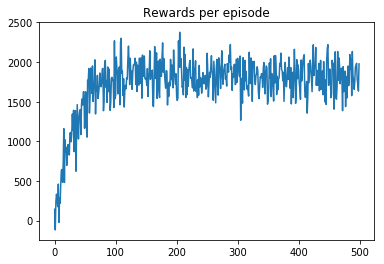

In [13]:
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

##### We can see from the above plot that the rewards converge at around 1700. Since the initial state is picked to be random for each episode, some initial states may be less rewarding than others inherently regardless of the model quality.

#### Epsilon-decay function for this model.

In [14]:
time = np.arange(0,2000)
epsilon_ = 1
epsilon_decay = 0.99
epsilon_min = 0.005
epsilon = []

for i in range(0,2000):
    if epsilon_ > epsilon_min:
        epsilon_ *= epsilon_decay
    epsilon.append(epsilon_)

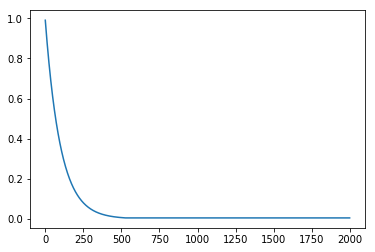

In [15]:
plt.plot(time, epsilon)
plt.show()

#### Epsilon-decay sample function

In [16]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

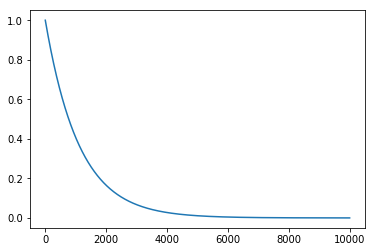

In [17]:
plt.plot(time, epsilon)
plt.show()